In [1]:
%matplotlib inline
import warnings
from brian2 import *
from brian2.hears import *
import ipywidgets as ipw
from scipy.optimize import curve_fit


WARNING    You are using the bridge between Brian 2 and Brian Hears from Brian 1. This is not guaranteed to work in all cases that brian.hears works. See the limitations in the online documentation. [brian2.hears]


In [2]:
warnings.filterwarnings("ignore")
def tunCurve(index,numItds,freq,timeConst,numrep):
    sound=tone(freq*Hz, 1*second)                 
    sound.level=90*dB
    hset = HeadlessDatabase(numItds).load_subject()    
    #print hset.coordinates['itd']
    
    num_indices = hset.num_indices   
    
    hf = hset.hrtf[index]
    hf_fb = hf.filterbank(sound)
    
    
    cochlea = FunctionFilterbank(hf_fb, lambda x:15*clip(x, 0, Inf)**(1.0/3.0))
    # Leaky integrate and fire neuron model
    eqs = '''
    dV/dt = (I-V)/(1*ms)+0.1*xi/(0.5*ms)**.5 : 1
    I : 1
    '''
    
    eqscd = '''
    dV/dt = (I-V)/(timeConst*ms)+0.1*xi/(0.5*ms)**.5 : 1
    I : 1
    '''
    
    
    
    G = FilterbankGroup(cochlea, 'I', eqs, reset='V=0', threshold='V>1', refractory=5*ms)
    # The coincidence detector (cd) neurons
    cd = NeuronGroup(numrep, eqscd, reset='V=0', threshold='V>1', clock=G.clock)
    C = Synapses(G, cd, 'we:1', pre='V += we')
    C.connect(True)
    for i in xrange(numrep):
        C.we[0,i]=0.6
        C.we[1,i]=0.6  
    
    
    MG=SpikeMonitor(G)
    Mcd=SpikeMonitor(cd)
    
    run(1*second)
    
    nsp=Mcd.num_spikes
   
    return nsp

In [3]:
def plottc(numItds=20,freq=500,timeConst=1,numrep=100):
    itds= HeadlessDatabase(numItds).load_subject().coordinates['itd']
    fr=np.zeros(numItds)
    gauss=np.zeros(numItds)
    
    for i in xrange(numItds):
        fr[i]=tunCurve(i,numItds,freq, timeConst,numrep)
    
    def gaus(x,a,x0,sigma):
        return a*exp(-(x-x0)**2/(2*sigma**2))
    
  
    
    popt,pcov =curve_fit(gaus,itds,fr,p0=[max(fr),0,1])
    
    plot(itds,fr,'b')   
    plot(itds,gaus(itds,*popt),'r')
  
    show()   

WARNING    The 'pre' keyword is deprecated, use 'on_pre' instead. [brian2.synapses.synapses.deprecated_pre]
INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.03s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
WARNING    Note that the synaptic pathway 'synapses_pre' will run on the clock of the group 'neurongroup' using a dt of 22.67573696 us. Either the Synapses object 'synapses' or the target 'neurongroup_1' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 22.67573696 us. If in doubt, try to ensure that 'neurongroup', 'synapses', and 'neurongroup_1' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]
INFO       No num

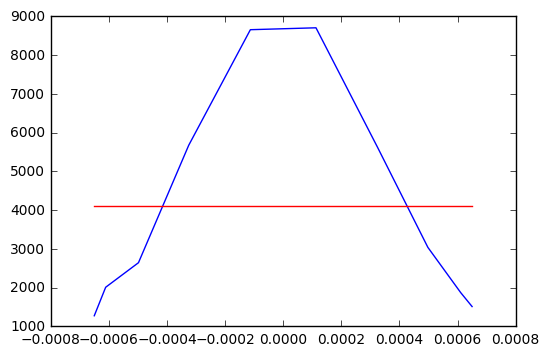

<function __main__.plottc>

In [4]:
ipw.interact(plottc,numItds=ipw.IntSlider(min=10, max=100, value=10, step=10, continuous_update=False),
             freq=ipw.IntSlider(min=100, max=10000, value=500, step=100, continuous_update=False),
             timeConst=ipw.IntSlider(min=1, max=10, value=1, step=1, continuous_update=False),
             numrep=ipw.IntSlider(min=10, max=500, value=50, step=10, continuous_update=False))
             
             
             
             